# Two phase flow in porous media
The two phae flow equation in porous media read
$$\varphi \frac{\partial S_w}{\partial t} + \nabla . \mathbf{u_w} = 0 .$$

The velocity of the water phase is calculated by
$$\mathbf{u_w}= -\frac{k k_{rw}}{\mu_w}(\nabla{p_w}-\rho_w \mathbf{g})$$

For the 1D flow of incompressible fluids, in which an incompressible fluid is injected with a volumetric flow rate of $q$ the magnitude of the water phase velocity at each cross section of the domain with area $A$ can be calculated by
$$u_w = f_w q/A$$
where the fractional flow of water $f_w$ is calculated by
$$f_w = \frac{\lambda_w}{\lambda_w+\lambda_o}$$
The mobility of each phase $\lambda_\alpha$ is calculated by
$$\lambda_\alpha = \frac{k k_{r\alpha}}{\mu_\alpha}$$

The relative permeability of each phase $k_{r \alpha}$ is generally and conveniently (and wrongly) assumed to be a function of the phase saturation. One such function is Brooks-Corey equations:
$$k_{rw} = k_{rw}^0 \left( \frac{S_w-S_{wc}}{1-S_{wc}-S_{or}} \right)^{n_w}$$
$$k_{ro} = k_{rw}^0 \left( \frac{1-S_w-S_{or}}{1-S_{wc}-S_{or}} \right)^{n_o}$$

The connate (or better stated irreducible) water saturation $S_{wc}$, residual (or remaining) oil saturation $S_{or}$, and the exponents ($n_o$, $n_w$) and end-points ($k_{rw}^0$, $k_{ro}^0$) are measured in the lab.

In Cartesian coordinate (1D), it reads
$$\varphi \frac{\partial S_w}{\partial t} + u\frac{\partial f_w}{\partial x} = 0$$

and in a radial coordinate, it reads
$$\varphi \frac{\partial S_w}{\partial t} + \frac{u}{r}\frac{\partial (r f_w)}{\partial r} = 0$$

To make these equations dimensionless, we define the following dimensionless time and space variables:
$$X = x/L,$$
$$\tau = t u/(L\varphi)$$
Then we obtain
$$\frac{\partial S_{w}}{\partial\tau}+\frac{df_{w}}{dS_{w}}\frac{\partial S_{w}}{\partial X}=0$$

The above equation, after some mathematical operation, can be written as
$$\left(\frac{d X}{d \tau}\right)_{S_w}=\frac{d f_w}{d S_w}$$
or for each saturation value, the speed by which the phase moves is calculated by the slope of the fractional flow curve:
$$X=\frac{d f_w}{d S_w}\tau$$

Let's see how it works in action.

## Define the parameters
Here, I define the parameters in SymPy and plot the fuctions.

In [120]:
import sympy as sympy
import mpmath as mpmath
import numpy as np
import matplotlib.pyplot as plt

In [121]:
s_w = sympy.symbols('s_w')
k_rw0 = 0.3
k_ro0 = 0.9
n_w   = 4.2
n_o   = 2.0
s_or  = 0.1
s_wc  = 0.15
mu_w = 0.001   # Pa.s
mu_o  = 0.003  # Pa.s
k_rw = k_rw0*((s_w-s_wc)/(1-s_wc-s_or))**n_w
k_ro = k_ro0*((1.0-s_w-s_or)/(1-s_wc-s_or))**n_o
lambda_w = k_rw/mu_w
lambda_o = k_ro/mu_o
f_w = lambda_w/(lambda_w+lambda_o)
df_w = sympy.diff(f_w, s_w)

## Relative permeability
Here's the shape of relative permeability curves, that resembles a typical water-wet system.

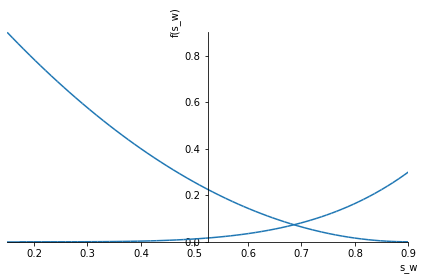

In [122]:
p1 = sympy.plot(k_rw, (s_w, s_wc, 1-s_or), show=False)
p2 = sympy.plot(k_ro, (s_w, s_wc, 1-s_or), show=False)
p1.append(p2[0])
p1.show()

## The saturation profile
Using the last equation, we calculate the saturation profile for a fixed $X/\tau$. By changing the value of, e.g., $X$, we will obtain the saturation profile:

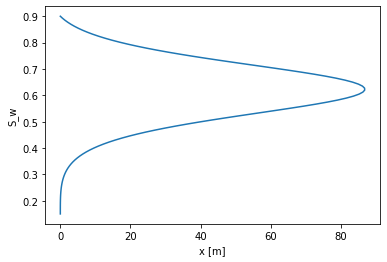

In [123]:
u   = 1e-5 # m/s
phi = 0.4
L   = 100 # m
t_inj = 100*24*3600 # s
t_calc = 10*24*3600 # s time at which the aturation profile is calculated
tau_calc = t_calc*u/(L*phi)
x_prf = sympy.lambdify(s_w, df_w*tau_calc*L, modules=['numpy'])
sw_val = np.linspace(s_wc, 1-s_or, 100)

p_sw_profile = plt.plot(x_prf(sw_val), sw_val)
plt.xlabel('x [m]')
plt.ylabel('S_w');

The above profile is not correct, since it is impossible to have two different saturation at one position. This is addressed by Buckley and Leverett in their (engineering) landmark paper. The mathematical theory that addresses this problem is called method of characteristics.

## Shock front saturation
The shock front saturation is calculated by drawing a tangent line from the initial condition to the water fractional flow curve. The slope of the line gives the (dimensionless) speed by which the front moves. In `SymPy`, this can be calculated by solving the following equation:
$$\frac{d f_w}{d S_w}-\frac{f_w(S_{w,shock})-f_w(S_{w,init})}{S_{w,shock}-S_{w,init}}=0$$
The numerical solver can converge to different answers: a negative value, $S_{wc}$, and several other values. The right answer is in ($S_{wc}$, $S_{or}$) In the following, I assume that the porous medium is initially at connate water saturation.

In [124]:
# finding the shock front saturation and shock speed
sw_shock_temp = sympy.nsolve(df_w-(f_w/(s_w-s_wc)), 0.5*(s_wc+1-s_or))
sw_shock = sw_shock_temp
l = df_w.evalf(subs={s_w:sw_shock})*(s_w-s_wc)
print('Shock front saturation is', sw_shock)

Shock front saturation is 0.759230010991478


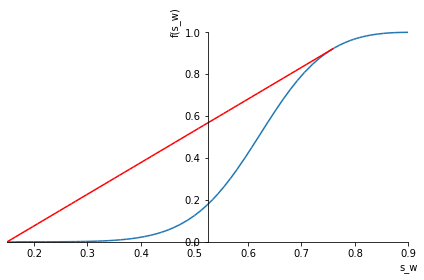

In [125]:
p1 = sympy.plot(f_w, (s_w, s_wc, 1-s_or), show=False)
p2 = sympy.plot(l, (s_w, s_wc, sw_shock), line_color='r', show=False)
p1.append(p2[0])
p1.show()

## The Buckley-Leverett solution
Looking at the above figure, one can observe that moving from the right side (injection point, beginning of the domain) the slope keeps increasing. and as soon as we get to the shock front, we switch to the tangent line, not to let the slope to increase and decrease again (avoiding the change of curvature. Moving along this new path, we can plot a new saturation profile:

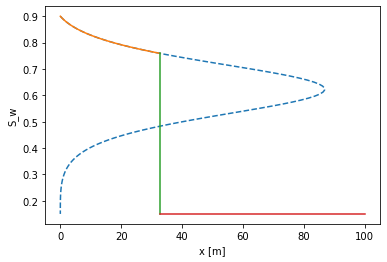

In [126]:
sw_val = np.linspace(1-s_or, s_wc, 100)
plt.plot(x_prf(sw_val), sw_val, '--')

sw_val = np.linspace(1-s_or, float(sw_shock), 100)

plt.plot(x_prf(sw_val), sw_val)
plt.plot([x_prf(sw_shock), x_prf(sw_shock)], [sw_shock, s_wc])
plt.plot([x_prf(sw_shock), L], [s_wc, s_wc])

plt.xlabel('x [m]')
plt.ylabel('S_w');

## Pressure drop
The total pressure drop is calculated by integrating the continuity equation:
$$$$